# Prediction Of Singapore HDB Prices

## Preparation

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression,ElasticNetCV,\
RidgeCV,LassoCV,Ridge,Lasso,ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, \
cross_val_predict,GridSearchCV,cross_validate
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import warnings
import csv
warnings.filterwarnings('ignore')

### Read Csv into data frame

In [2]:
df = pd.read_csv("../data/train.csv")
df.head(2)

,id,Tranc_YearMonth,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,...,vacancy,pri_sch_affiliation,pri_sch_latitude,pri_sch_longitude,sec_sch_nearest_dist,sec_sch_name,cutoff_point,affiliation,sec_sch_latitude,sec_sch_longitude
0,88471,2016-05,KALLANG/WHAMPOA,4 ROOM,3B,UPP BOON KENG RD,10 TO 12,90.0,Model A,2006,...,78,1,1.317659,103.882504,1138.633422,Geylang Methodist School,224,0,1.317659,103.882504
1,122598,2012-07,BISHAN,5 ROOM,153,BISHAN ST 13,07 TO 09,130.0,Improved,1987,...,45,1,1.349783,103.854529,447.894399,Kuo Chuan Presbyterian Secondary School,232,0,1.350110,103.854892


## Data cleaning and feature selection

### Check shape, nulls, zeroes and data type

In [3]:
print(f"Data frame shape: {df.shape}")
print("\n")
nulls = {k:v for k,v in dict(df.isnull().sum()).items() if v>0}
for k,v in nulls.items():
    print(f"Empty rows in column [{k}]: {v}")
print("\n")
zeroes = {k:v for k,v in dict(df[df == 0].count()).items() if v>0}
for k,v in zeroes.items():
    print(f"Rows with zeroes in column [{k}]: {v}")
print("\n")

column_types = {str(k):list(v) for k,v in df.groupby(df.dtypes,axis=1)}
for k,v in column_types.items():
    print(f"Columns with data type [{k}]:{v}")
    print("\n")

Data frame shape: (150634, 77)


Empty rows in column [Mall_Nearest_Distance]: 829
Empty rows in column [Mall_Within_500m]: 92789
Empty rows in column [Mall_Within_1km]: 25426
Empty rows in column [Mall_Within_2km]: 1940
Empty rows in column [Hawker_Within_500m]: 97390
Empty rows in column [Hawker_Within_1km]: 60868
Empty rows in column [Hawker_Within_2km]: 29202


Rows with zeroes in column [1room_sold]: 150552
Rows with zeroes in column [2room_sold]: 144324
Rows with zeroes in column [3room_sold]: 95671
Rows with zeroes in column [4room_sold]: 30379
Rows with zeroes in column [5room_sold]: 62782
Rows with zeroes in column [exec_sold]: 124614
Rows with zeroes in column [multigen_sold]: 150557
Rows with zeroes in column [studio_apartment_sold]: 149226
Rows with zeroes in column [1room_rental]: 150332
Rows with zeroes in column [2room_rental]: 148770
Rows with zeroes in column [3room_rental]: 146805
Rows with zeroes in column [other_room_rental]: 150602
Rows with zeroes in column [Mall_

### Feature Engineering

In [4]:
df['hdb_age_at_tranc'] = df['Tranc_Year']-df['lease_commence_date']

### Imputation of null values

In [5]:
col = ['Hawker_Within_2km','Mall_Within_2km', 'Mall_Nearest_Distance' ]
for i in col:
    mean = np.mean(df[i])
    df[i].fillna(value=mean, inplace=True)

### Manual splitting into categories and numerical features

In [6]:
numerical_columns = []
categorical_columns = []

filename = "../data/data_dictionary_analysis.csv"
with open(filename,'r') as data:
    reader = csv.reader(data)
    next(reader, None)  # skip the headers
    for line in reader:
        if line[3]=='1' and line[4] == 'numerical':
            numerical_columns.append(line[1])
        if line[3]=='1' and line[4] == 'Categorical':
            categorical_columns.append(line[1])


### Check data types

In [7]:
for i in numerical_columns:
    print(f"Column [{i}] has data type [{df[i].dtype}]")
    
for i in categorical_columns:
    print(f"Column [{i}] has data type [{df[i].dtype}] has unique counts [{len(set(df[i]))}]")

Column [floor_area_sqm] has data type [float64]
Column [mid] has data type [int64]
Column [max_floor_lvl] has data type [int64]
Column [Mall_Nearest_Distance] has data type [float64]
Column [Mall_Within_2km] has data type [float64]
Column [Hawker_Nearest_Distance] has data type [float64]
Column [Hawker_Within_2km] has data type [float64]
Column [mrt_nearest_distance] has data type [float64]
Column [cutoff_point] has data type [int64]
Column [hdb_age_at_tranc] has data type [int64]
Column [flat_type] has data type [object] has unique counts [7]
Column [flat_model] has data type [object] has unique counts [20]
Column [Tranc_Year] has data type [int64] has unique counts [10]
Column [planning_area] has data type [object] has unique counts [32]
Column [bus_interchange] has data type [int64] has unique counts [2]
Column [mrt_interchange] has data type [int64] has unique counts [2]


## EDA

### Correlation heat map of numerical columns

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 [Text(0.5, 0, 'floor_area_sqm'),
  Text(1.5, 0, 'mid'),
  Text(2.5, 0, 'max_floor_lvl'),
  Text(3.5, 0, 'Mall_Nearest_Distance'),
  Text(4.5, 0, 'Mall_Within_2km'),
  Text(5.5, 0, 'Hawker_Nearest_Distance'),
  Text(6.5, 0, 'Hawker_Within_2km'),
  Text(7.5, 0, 'mrt_nearest_distance'),
  Text(8.5, 0, 'cutoff_point'),
  Text(9.5, 0, 'hdb_age_at_tranc'),
  Text(10.5, 0, 'resale_price')])

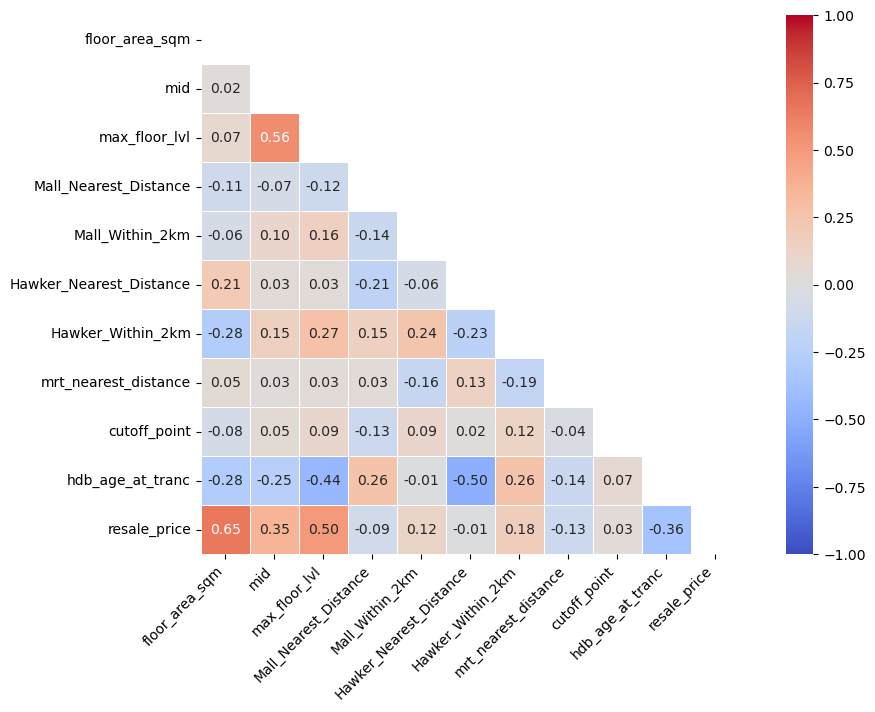

In [8]:
# Use Seaborn's heatmap with pandas .corr() to visualize correlations between all numeric features.
corr = df[numerical_columns+['resale_price']].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (12,7))
sns.heatmap(corr, mask = mask, square = True, annot = True, vmin = -1, vmax = 1, linewidths = .5, cmap = "coolwarm",fmt='.2f')
plt.xticks(rotation=45, ha='right') 

### Bar charts for categorical features

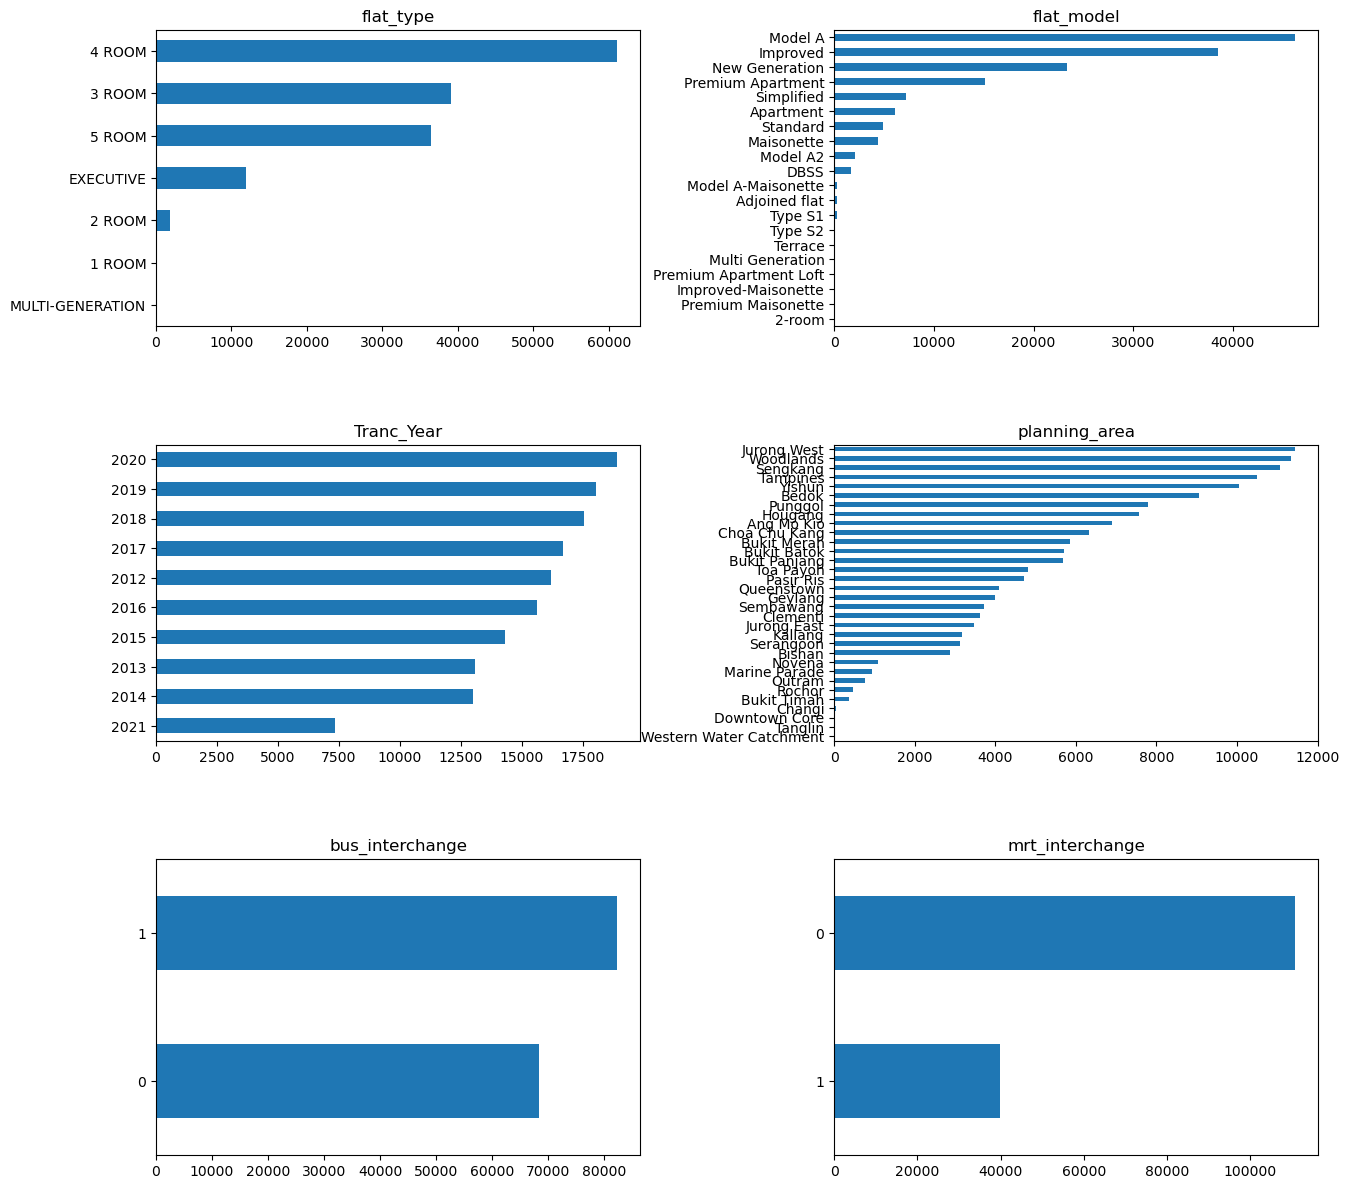

In [9]:
# Visualize categories
fig1 = plt.figure(figsize=(15,20))
fig1.subplots_adjust(hspace=0.4,wspace=0.4)

for idx, d in enumerate(categorical_columns):
    fig1.add_subplot(4,2,idx+1)
    df[d].value_counts().sort_values().plot(kind='barh')
    plt.title(d)

### Histogram for numerical features

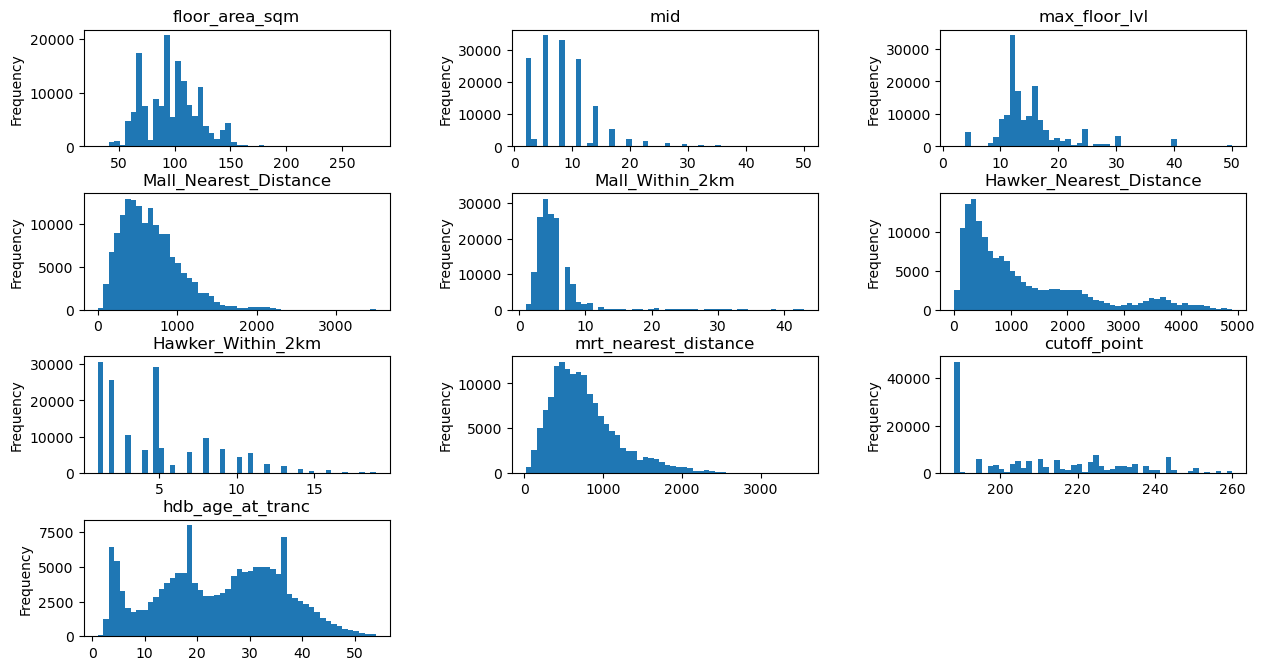

In [10]:
fig1b = plt.figure(figsize=(15,10))
fig1b.subplots_adjust(hspace=0.4,wspace=0.4)

for idx, d in enumerate(numerical_columns):
    fig1b.add_subplot(5,3,idx+1)
    df[d].plot(kind='hist',bins=50,title=d)

### Box plots for outliers

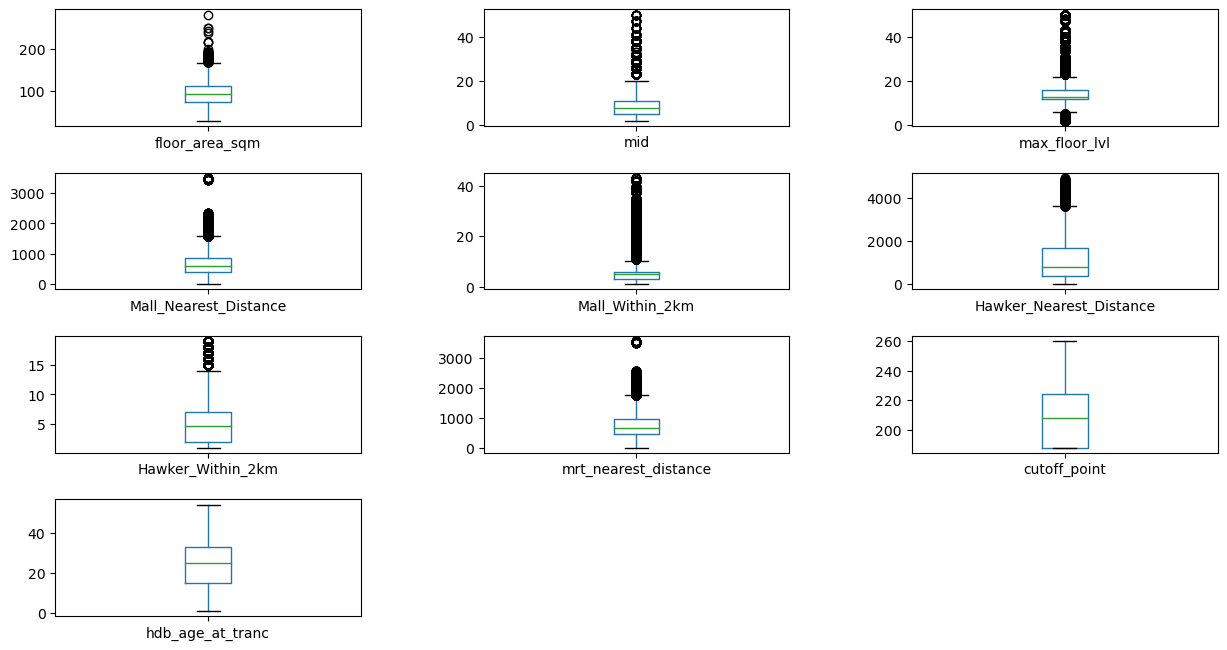

In [11]:
# Plot and interpret boxplots
fig2 = plt.figure(figsize=(15,10))
fig2.subplots_adjust(hspace=0.4,wspace=0.4)

for idx, d in enumerate(numerical_columns):
    fig2.add_subplot(5,3,idx+1)
    bp = df.boxplot(column=d, grid=False)

### Scatter plots by Flat types

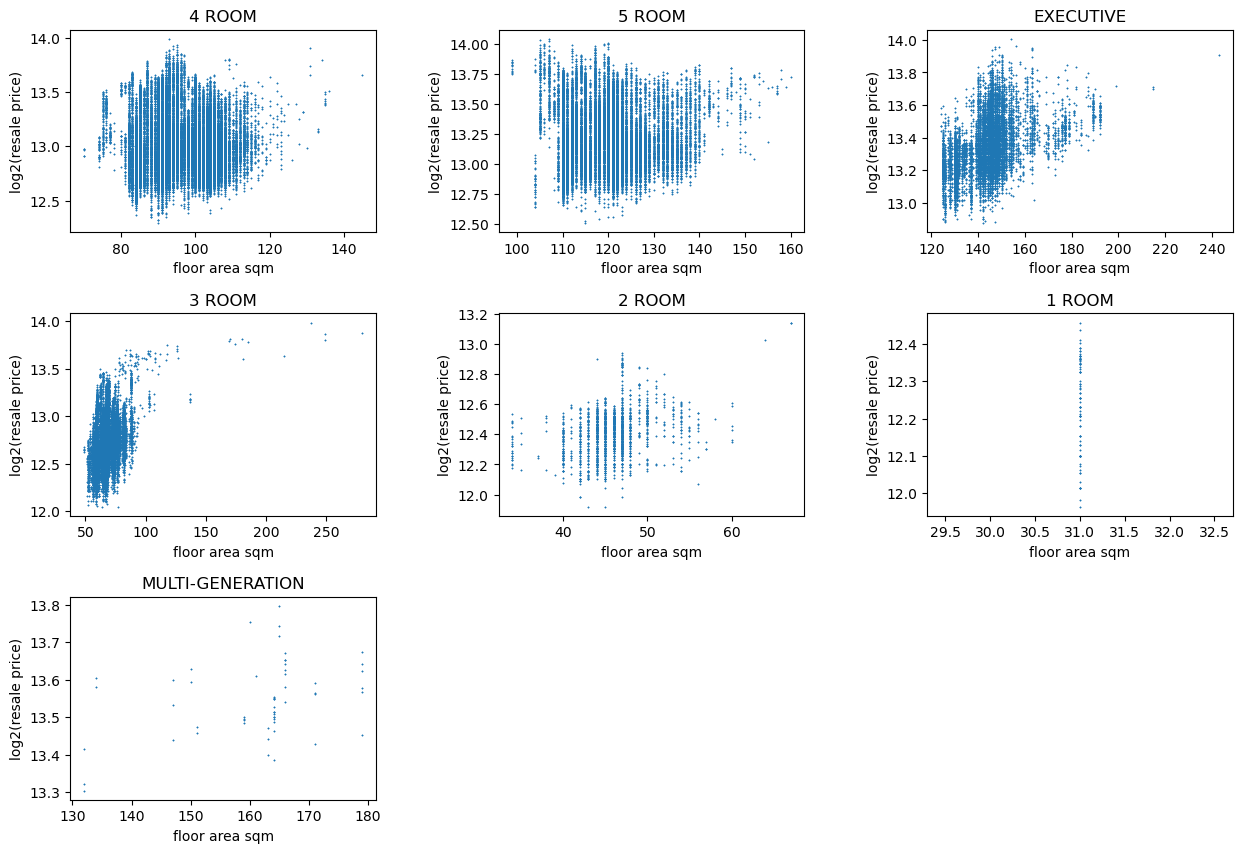

In [12]:
fig3 = plt.figure(figsize=(15,10))
fig3.subplots_adjust(hspace=0.4,wspace=0.4)

for idx, d in enumerate(df['flat_type'].unique()):
    x = df.loc[df['flat_type']==d]['floor_area_sqm']
    y = np.log(df.loc[df['flat_type']==d]['resale_price'])
    fig3.add_subplot(3,3,idx+1)
    plt.scatter(x,y, marker='*',s=0.1)
    plt.xlabel('floor area sqm')
    plt.ylabel('log2(resale price)')
    plt.title(d)

### Scatter plots by Planning area

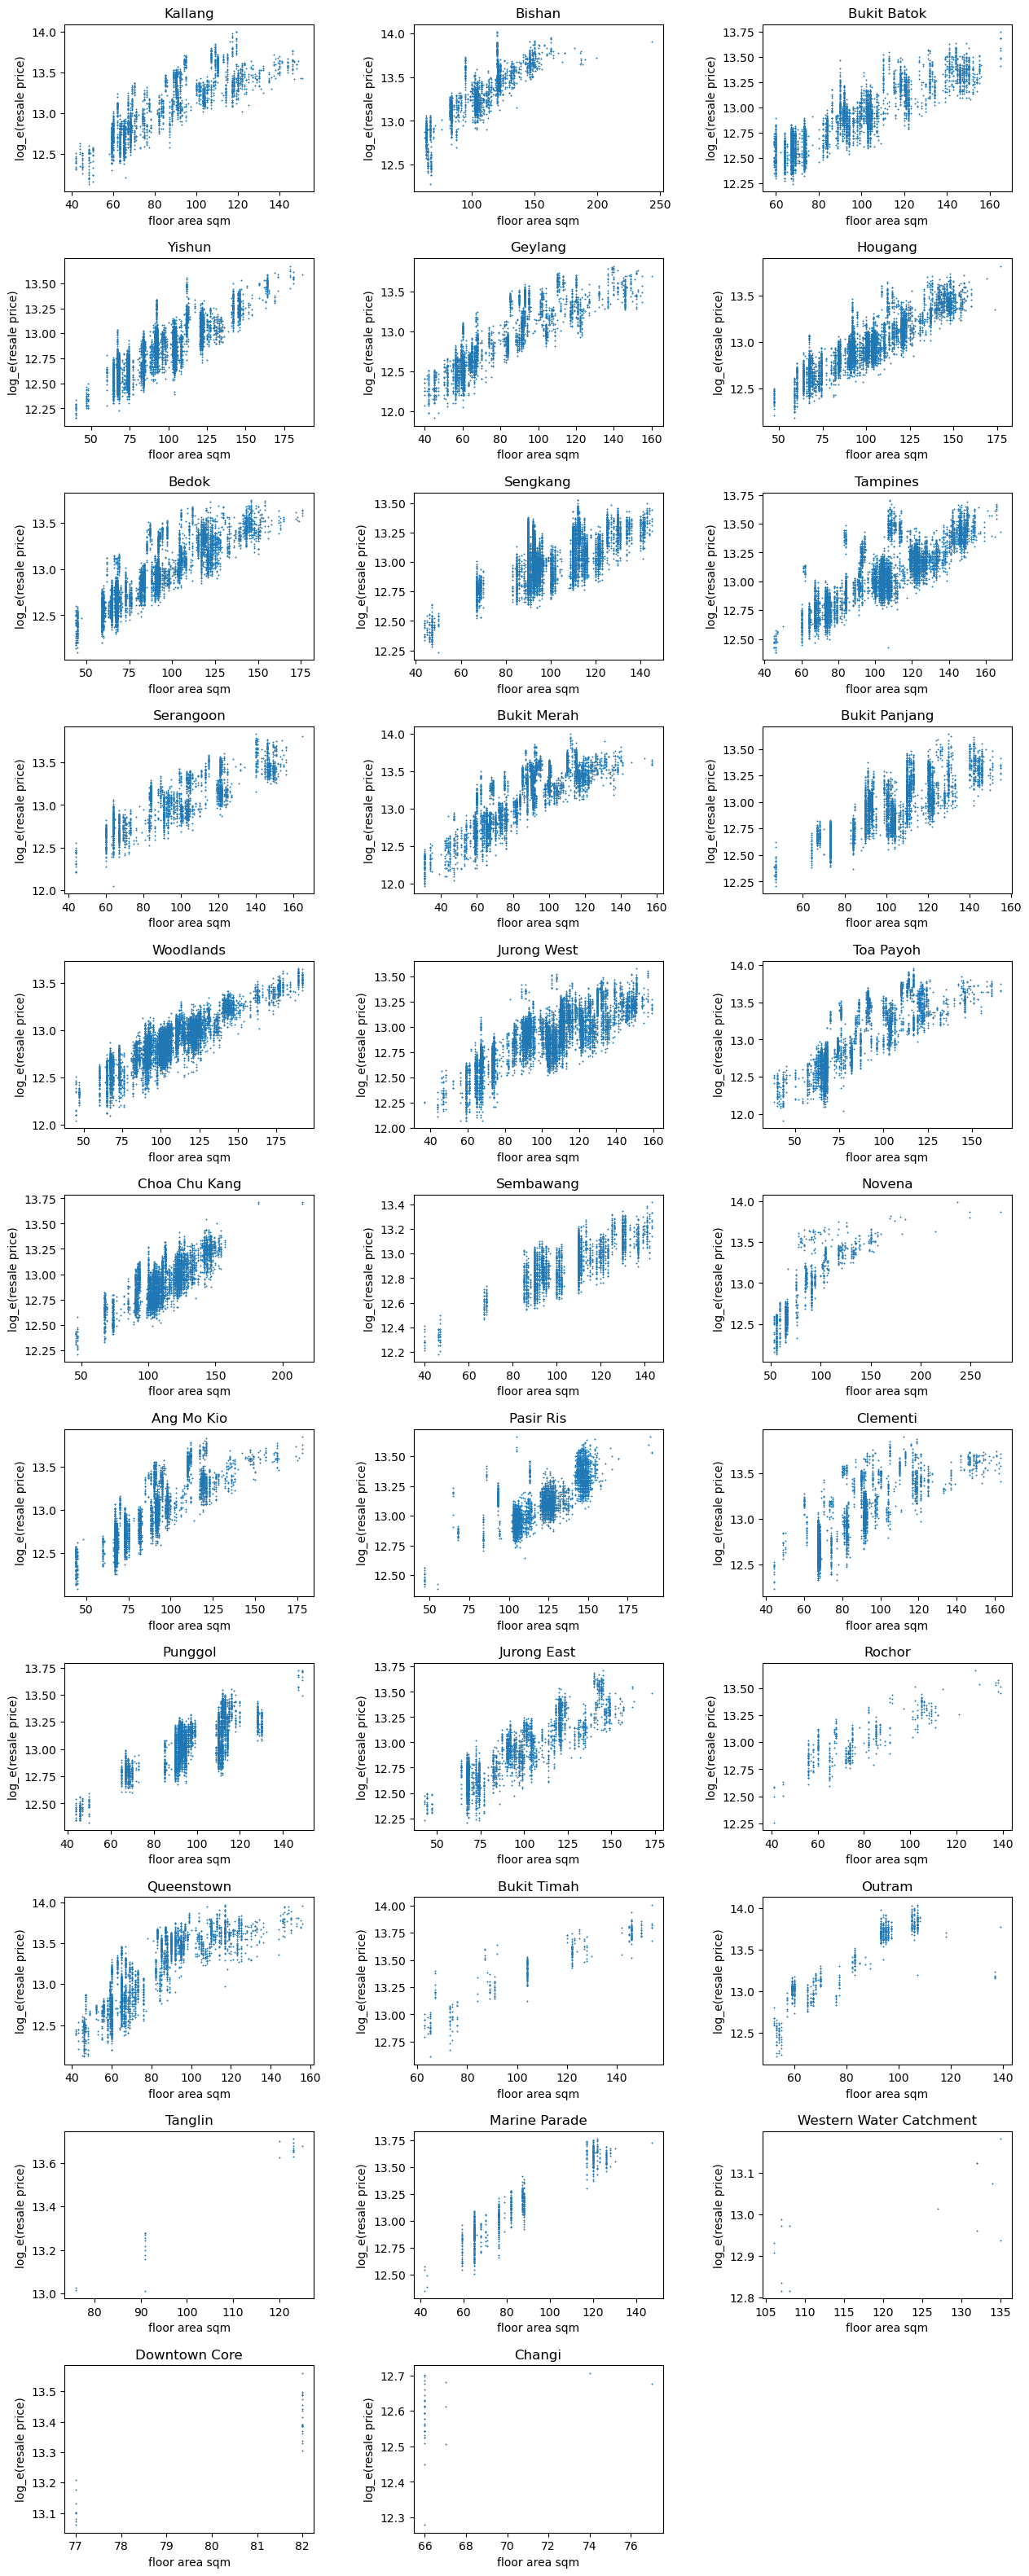

In [13]:
fig4 = plt.figure(figsize=(15,40))
fig4.subplots_adjust(hspace=0.4,wspace=0.4)

#x = df.loc[(df[indicator]==d) & (df['flat_type']=='5 ROOM')]['floor_area_sqm']
#y = np.log(df.loc[(df[indicator]==d) & (df['flat_type']=='5 ROOM')]['resale_price'])

indicator = 'planning_area'
for idx, d in enumerate(df[indicator].unique()):
    x = df.loc[(df[indicator]==d)]['floor_area_sqm']
    y = np.log(df.loc[(df[indicator]==d)]['resale_price'])
    fig4.add_subplot(11,3,idx+1)
    plt.scatter(x,y, marker='*',s=0.1)
    plt.xlabel('floor area sqm')
    plt.ylabel('log_e(resale price)')
    plt.title(d)

## Feature Engineering and Selection

### Use logarithm value of predicted value

In [14]:
df['resale_price'] = np.log(df['resale_price'])

In [15]:
# Set up X and y.
X= df[numerical_columns+categorical_columns]
y= df['resale_price']

nulls = {k:v for k,v in dict(X.isnull().sum()).items() if v>0}
for k,v in nulls.items():
    print(f"Empty rows in column [{k}]: {v}")

### Train and Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 42)

## Model Building

In [17]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

preprocessor = ColumnTransformer([
    ('one-hot-encoder', categorical_preprocessor, categorical_columns),
    ('standard_scaler', numerical_preprocessor, numerical_columns)])

model = ElasticNet(alpha=0.001)

pipe = make_pipeline(preprocessor, model)
pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('one-hot-encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['flat_type', 'flat_model',
                                                   'Tranc_Year',
                                                   'planning_area',
                                                   'bus_interchange',
                                                   'mrt_interchange']),
                                                 ('standard_scaler',
                                                  StandardScaler(),
                                                  ['floor_area_sqm', 'mid',
                                                   'max_floor_lvl',
                                                   'Mall_Nearest_Distance',
                                                   'Mall_Within_2km',
                                                   'Hawker_Nearest_Distance',
                                                   'Hawker_Within_2km',
                                                   'mrt_nearest_distance',
                                                   'cutoff_point',
                                                   'hdb_age_at_tranc'])])),
                ('elasticnet', ElasticNet(alpha=0.001))])

## Model Evaluation

In [18]:
print(f"Train score = {pipe.score(X_train,y_train)}")
print(f"Test score = {pipe.score(X_test,y_test)}")

Train score = 0.8948760479699465
Test score = 0.8930538075430288


In [19]:
cv_results = cross_validate(pipe, X_train, y_train, cv=5)
scores = cv_results["test_score"]
print("The mean cross-validation accuracy is: "
      f"{scores.mean():.3f} ± {scores.std():.3f}")

The mean cross-validation accuracy is: 0.895 ± 0.001


In [20]:
#pipe.get_feature_names_out

In [21]:
def get_feature_names():  
    column_transformer = preprocessor      
    new_feature_names = []
    for i, transformer_item in enumerate(column_transformer.transformers_):        
        transformer_name, transformer, orig_feature_names = transformer_item
        orig_feature_names = list(orig_feature_names)                
        if hasattr(transformer, 'get_feature_names'):
            if 'input_features' in transformer.get_feature_names.__code__.co_varnames:
                names = list(transformer.get_feature_names(orig_feature_names))
            else:
                names = list(transformer.get_feature_names())
        new_feature_names.extend(names)       
    return new_feature_names

sorted(list(zip(np.round(pipe[1].coef_,2),get_feature_names())),key=lambda x: abs(x[0]),reverse=True)

[(0.36, 'x3_Marine Parade'),
 (0.22, 'x0_1 ROOM'),
 (-0.2, 'x3_Woodlands'),
 (-0.16, 'x3_Sembawang'),
 (0.14, 'x3_Bishan'),
 (0.12, 'x3_Bukit Timah'),
 (-0.12, 'x3_Choa Chu Kang'),
 (0.11, 'x3_Queenstown'),
 (0.11, 'x3_Serangoon'),
 (-0.1, 'x3_Jurong West'),
 (-0.1, 'x1_Apartment'),
 (0.09, 'x1_DBSS'),
 (-0.09, 'x3_Bukit Panjang'),
 (0.09, 'x3_Clementi'),
 (-0.08, 'x0_2 ROOM'),
 (0.08, 'x2_2013'),
 (0.06, 'x2_2021'),
 (-0.06, 'x3_Yishun'),
 (-0.06, 'x0_EXECUTIVE'),
 (0.06, 'x0_MULTI-GENERATION'),
 (0.05, 'x2_2012'),
 (-0.05, 'x1_2-room'),
 (-0.04, 'x1_Model A'),
 (0.04, 'x3_Punggol'),
 (-0.04, 'x3_Sengkang'),
 (0.04, 'x3_Tampines'),
 (0.04, 'x0_2 ROOM'),
 (0.03, 'x0_4 ROOM'),
 (-0.03, 'x2_2018'),
 (-0.03, 'x2_2019'),
 (0.03, 'x3_Bukit Merah'),
 (0.03, 'x0_3 ROOM'),
 (-0.02, 'x1_Improved'),
 (0.02, 'x1_Maisonette'),
 (0.02, 'x2_2014'),
 (-0.01, 'x2_2017'),
 (-0.01, 'x3_Ang Mo Kio'),
 (-0.01, 'x3_Bedok'),
 (0.01, 'x3_Toa Payoh'),
 (-0.01, 'x5_0'),
 (-0.01, 'x0_4 ROOM'),
 (-0.0, 'x0_1 ROO